# Matlab Model Sync

## Simulator (Valid)

Systematically testing each aspect of the Python/Matlab UAV models to ensure they match as close as possible

In [56]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import numpy as np
import pandas as pd
from multirotor.coords import body_to_inertial, direction_cosine_matrix, inertial_to_body

In [57]:
scenarios = ['faulty', 'nominal', 'python']
modes = ['before_g', 'after_g']
skip = False

scenario = scenarios[1]
mode = modes[0]

## Simulating Forces and Moments

In [58]:
# importing from matlab
if skip:
    nominal_f = pd.read_csv(f'../data/{scenario}_f_skip.csv', header=None)
    nominal_t = pd.read_csv(f'../data/{scenario}_m_skip.csv', header=None)
    nominal_states = pd.read_csv(f'../data/{scenario}_states_skip.csv', header=None)
else:
    if scenario == 'python':
        nominal_f = np.array(pd.read_csv(f'../data/my_fs.csv', header=None))[1:,1:4]
        nominal_t = np.array(pd.read_csv(f'../data/my_ts.csv', header=None))[1:,1:4]

        nominal_states = pd.read_csv(f'../data/nominal_states.csv', header=None)
    else:
        nominal_f = pd.read_csv(f'../data/{scenario}_f.csv', header=None)
        nominal_t = pd.read_csv(f'../data/{scenario}_m.csv', header=None)
        
        nominal_states = pd.read_csv(f'../data/{scenario}_states.csv', header=None)

In [59]:
# plt.plot(nominal_f[:,2])

# tmp_f = pd.read_csv(f'../data/nominal_f.csv', header=None)
# tmp_t = pd.read_csv(f'../data/nominal_m.csv', header=None)

# plt.plot(np.array(tmp_f)[:,5], linestyle=':')

In [60]:
# plt.plot(np.array(nominal_t)[:,0])

# tmp_f = pd.read_csv(f'../data/nominal_f.csv', header=None)
# tmp_t = pd.read_csv(f'../data/nominal_m.csv', header=None)

# plt.plot(np.array(tmp_t)[:,0], linestyle=':')

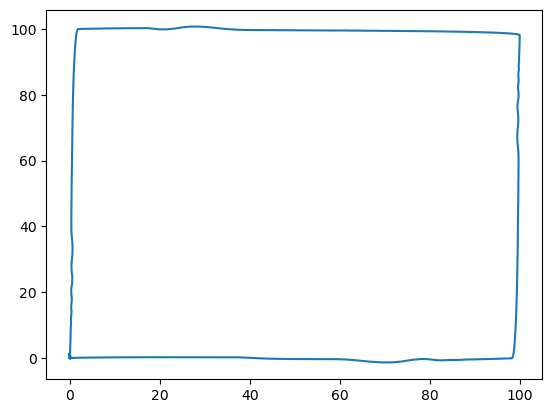

In [61]:
state_array = np.array(nominal_states)
plt.plot(state_array[:,0], state_array[:,1])

In [62]:
def apply_forces_torques(
    forces: np.ndarray, torques: np.ndarray, x: np.ndarray, g: float, mass: float,
    inertia_matrix: np.matrix, inertia_matrix_inverse: np.matrix
) -> np.ndarray:
    """
    Given forces and torqes, return the rate of change of state.

    Parameters
    ----------
    forces : np.ndarray
        Forces acting in the body frame.
    torques : np.ndarray
        Torques acting in the body frame.
    x : np.ndarray
        State of the vehicle.
    g : float
        Gravitational acceleration.
    mass : float
        Mass of the vehicle.
    inertia_matrix : np.matrix
        Inertial matrix.
    inertia_matrix_inverse : np.matrix
        Inverse of inertial matrix.

    Returns
    -------
    np.ndarray
        The rate of change of state d(state)/dt
    """
    # Store state variables in a readable format
    xI = x[0]       # Inertial frame positions
    yI = x[1]
    zI = x[2]
    ub = x[3]       # linear velocity along body-frame-x-axis b1
    vb = x[4]       # linear velocity along body-frame-y-axis b2
    wb = x[5]       # linear velocity along body-frame-z-axis b3
    phi = x[6]      # Roll
    theta = x[7]    # Pitch
    psi = x[8]      # Yaw
    p = x[9]        # body-frame-x-axis rotation rate
    q = x[10]       # body-frame-y-axis rotation rate
    r = x[11]       # body-frame-z-axis rotation rate
    
    # Pre-calculate trig values
    cphi = np.cos(phi);   sphi = np.sin(phi)    # roll
    cthe = np.cos(theta); sthe = np.sin(theta)  # pitch
    cpsi = np.cos(psi);   spsi = np.sin(psi)    # yaw

    f1, f2, f3 = forces # in the body frame (b1, b2, b3)
    t1, t2, t3 = torques
    I = inertia_matrix
    I_inv = inertia_matrix_inverse
    
    # Calculate the derivative of the state matrix using EOM
    xdot = np.zeros_like(x)

    # velocity = dPosition (inertial) / dt (convert body velocity to inertial)
    # Essentially = Rotation matrix (body to inertial) x body velocity
    # dcm = direction_cosine_matrix(roll=phi, pitch=theta, yaw=psi)
    # xdot[0:3] = body_to_inertial(x[3:6], dcm)
    xdot[0] = cthe*cpsi*ub + (-cphi * spsi + sphi*sthe*cpsi) * vb + \
        (sphi*spsi+cphi*sthe*cpsi) * wb  # = xIdot 
    xdot[1] = cthe*spsi * ub + (cphi*cpsi+sphi*sthe*spsi) * vb + \
        (-sphi*cpsi+cphi*sthe*spsi) * wb # = yIdot 
    xdot[2] = (-sthe * ub + sphi*cthe * vb + cphi*cthe * wb) # = zIdot

    #  Acceleration = dVelocity (body frame) / dt
    #           External forces     Gravity             Coriolis effect
    xdot[3] = 1/mass * (f1)     + g * sthe          + r * vb - q * wb  # = udot
    xdot[4] = 1/mass * (f2)     - g * sphi * cthe   - r * ub + p * wb # = vdot
    xdot[5] = 1/mass * (f3)     - g * cphi * cthe   + q * ub - p * vb # = wdot

    # Orientation
    xdot[6] = p + (q*sphi + r*cphi) * sthe / cthe  # = phidot
    xdot[7] = q * cphi - r * sphi  # = thetadot
    xdot[8] = (q * sphi + r * cphi) / cthe  # = psidot

    # Angular rate
    gyro = np.cross(x[9:12], I @ x[9:12])
    xdot[9:12] = I_inv @ (torques - gyro)

    return xdot


def dxdt_speeds(t: float, x: np.ndarray, forces:np.ndarray, torques:np.ndarray, params=None
    ):
        """
        Calculate the rate of change of state given the propeller speeds on the
        system (rad/s).

        Parameters
        ----------
        t : float
            Time. Currently this function is time invariant.
        x : np.ndarray
            State of the vehicle.
        u : np.ndarray
            A p-vector of propeller speeds (rad/s), where p=number of propellers.
        disturb_forces : np.ndarray, optional
            Disturbinng x,y,z forces in the vehicle's local frame, by default 0.
        disturb_torques : np.ndarray, optional
            Disturbing x,y,z torques in the vehicle's local frame, by default 0.

        Returns
        -------
        np.ndarray
            The rate of change of state.
        """
        inertia_matrix=np.asarray([
            [0.2506, 0, 0],
            [0, 0.2506, 0.],
            [0, 0, 0.4538]
        ])
        # print('dxdt-x', self.t // self.simulation.dt, x.dtype)
        if mode == 'before_g':
             g = 9.8
        elif mode == 'after_g':
             g = 0
        dxdt = apply_forces_torques(forces, torques, x, g, 10.66, inertia_matrix, np.linalg.inv(inertia_matrix).round(4))
        # print('dxdt', self.t // self.simulation.dt, dxdt.dtype)
        return dxdt

# def simulate_f_t(forces, torques, initial_state):
#     state = initial_state
#     log = []

#     for f, t in zip(forces, torques):
#         # f += np.random.normal(0, 1e-4)
#         # t += np.random.normal(0, 1e-3)
#         state = odeint(
#             dxdt_speeds, state, (0, 0.01),
#             args=(f, t),
#             rtol=1e-4, atol=1e-4, tfirst=True
#         )[-1]
#         dcm = direction_cosine_matrix(state[6], state[7], state[8])
#         dcm = dcm.astype(np.float32)
#         state_copy = np.array(state, dtype=np.float32)
#         state_copy[3:6] = body_to_inertial(state_copy[3:6], dcm)

#         log.append(state_copy)

#     return np.array(log)

# def simulate_f_t(forces, torques, initial_state):
#     state = initial_state
#     log = []

#     for f, t in zip(forces, torques):
#         # f = np.round(f * 10) / 10
#         # t += np.random.normal(0, 1e-3)
#         state = solve_ivp(dxdt_speeds, (0, 0.01), state, args=(f, t), method='RK45', t_eval=(0, 0.01), rtol=1e-12, atol=1e-12).y[:,-1]
#         dcm = direction_cosine_matrix(state[6], state[7], state[8])
#         dcm = dcm.astype(np.float32)
#         # state[3:6] = inertial_to_body(state[3:6], dcm)
#         # state = state.astype(np.float32)


#         state_copy = np.array(state, dtype=np.float32)
#         state_copy[3:6] = body_to_inertial(state_copy[3:6], dcm)

#         log.append(state_copy)

#     return np.array(log)

# def simulate_f_t(forces, torques, initial_state):
#     state = initial_state
#     log = []

#     for f, t in zip(forces, torques):
#         # f = np.round(f * 10) / 10
#         # t += np.random.normal(0, 1e-3)
#         state = solve_ivp(dxdt_speeds, (0, 0.01), state, args=(f, t), method='RK45', t_eval=(0, 0.01), rtol=1e-12, atol=1e-12).y[:,-1]
#         dcm = direction_cosine_matrix(state[6], state[7], state[8])
#         dcm = dcm.astype(np.float32)
#         # state[3:6] = inertial_to_body(state[3:6], dcm)
#         # state = state.astype(np.float32)


#         state_copy = np.array(state, dtype=np.float32)
#         state_copy[3:6] = body_to_inertial(state_copy[3:6], dcm)

#         log.append(state_copy)

#     return np.array(log)

# def simulate_f_t(forces, torques, states):
#     log = []

#     for f, t, s in zip(forces, torques, states):
#         # Velocities are recorded in the inertial frame
#         dcm = direction_cosine_matrix(s[6], s[7], s[8])
#         dcm = dcm.astype(np.float64)
#         s[3:6] = inertial_to_body(s[3:6], dcm)

#         state = solve_ivp(dxdt_speeds, (0, 0.01), state, args=(f, t), method='RK45', t_eval=(0, 0.01), rtol=1e-12, atol=1e-12).y[:,-1]
#         dcm = direction_cosine_matrix(state[6], state[7], state[8])
#         dcm = dcm.astype(np.float32)
#         state_copy = np.array(state, dtype=np.float32)
#         # For logging purposes, convert the velocities back to the inertial frame
#         state_copy[3:6] = body_to_inertial(state_copy[3:6], dcm)

#         log.append(state_copy)

#     return np.array(log)

In [63]:
import pybullet as p
import pybullet_data
import time

# Define a function to apply forces and torques to the object in PyBullet
def apply_force_torque(massId, force, torque):
    p.applyExternalForce(massId, -1, force, [0, 0, 0], p.LINK_FRAME)
    p.applyExternalTorque(massId, -1, torque, p.LINK_FRAME)

# Define the simulate_f_t function
def simulate_f_t(forces, torques, initial_state):

    physicsClient = p.connect(p.DIRECT)  # or p.DIRECT for non-graphical version
    # p.setAdditionalSearchPath(pybullet_data.getDataPath())
    p.setGravity(0, 0, 0)  # Set gravity in z direction
    p.setPhysicsEngineParameter(fixedTimeStep=0.01)  # Set the timestep to 0.01 seconds
    p.setTimeStep(0.01)

    # Create a plane as a ground
    # planeId = p.loadURDF("plane.urdf")

    # Load custom URDF file for the point mass
    mass_position = [0, 0, initial_state[2]]  # initial position of the point mass
    massId = p.loadURDF("./point_mass.urdf", mass_position)
    # Set linear and angular damping to zero to disable drag force
    linear_damping = 0.0
    angular_damping = 0.0
    p.changeDynamics(massId, -1, linearDamping=linear_damping, angularDamping=angular_damping)

    state = initial_state
    log = []

    for f, t in zip(forces, torques):
        apply_force_torque(massId, f, t)
        p.stepSimulation()

        # Get the current state of the point mass
        position, orientation = p.getBasePositionAndOrientation(massId)
        linear_velocity, angular_velocity = p.getBaseVelocity(massId)

        # Convert the quaternion orientation to a rotation matrix
        rot_matrix = p.getMatrixFromQuaternion(orientation)

        # Convert linear velocity to the world frame
        linear_velocity_world = np.dot(np.array(rot_matrix).reshape(3,3).T, linear_velocity)

        orientation = p.getEulerFromQuaternion(orientation)

        # Log the current state
        log.append([*position, *linear_velocity_world, *orientation, *angular_velocity])

    p.disconnect()

    return np.array(log)

In [64]:
if mode == 'before_g':
    if scenario == 'python':
        # log = simulate_f_t(np.array(nominal_f)[:,0:3], np.array(nominal_t)[:,0:3], np.array(nominal_states)[0])
        # log = simulate_f_t(np.array(nominal_f)[:,0:3], np.array(nominal_t)[:,0:3], np.array(nominal_states))
        pass
    else:
        log = simulate_f_t(np.array(nominal_f)[:,0:3], np.array(nominal_t)[:,0:3], np.array(nominal_states)[0])

elif mode == 'after_g':
    # log = simulate_f_t(np.array(nominal_f)[:,0:3], np.array(nominal_t)[:,0:3], np.array(nominal_states)[0])
    # log = simulate_f_t(np.array(nominal_f)[:,0:3], np.array(nominal_t)[:,0:3], np.array(nominal_states))
    pass

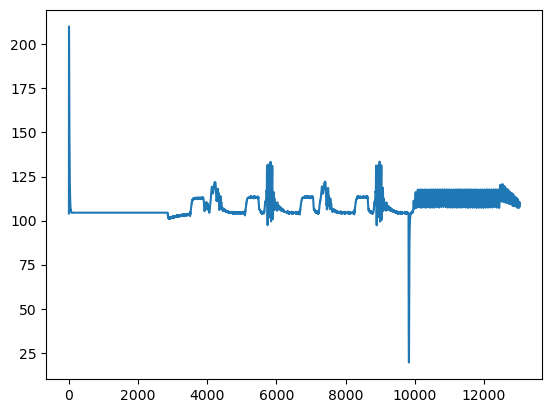

In [65]:
plt.plot(np.array(nominal_f)[:,5])

Text(0.5, 1.0, 'xy')

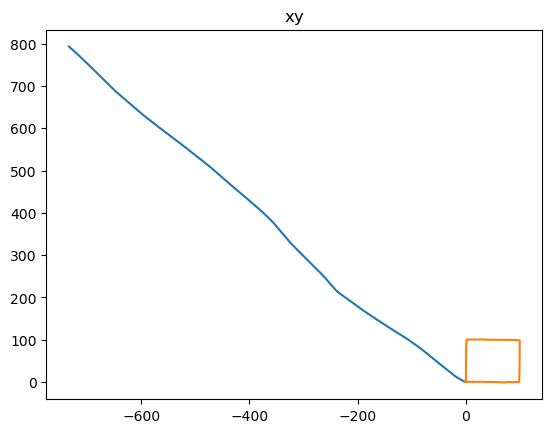

In [66]:
plt.plot(log[:,0], log[:,1])
plt.plot(state_array[:,0], state_array[:,1])
plt.title("xy")

Text(0.5, 1.0, 'x')

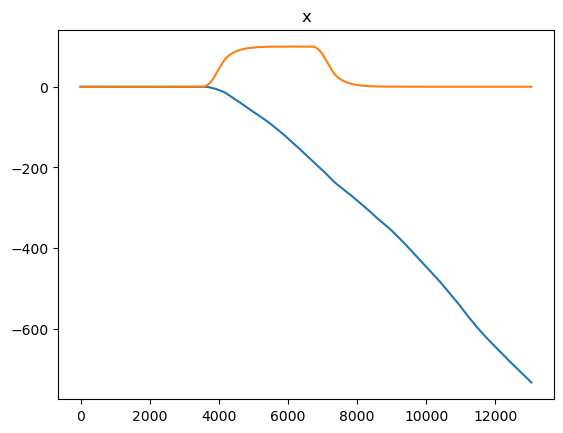

In [67]:
plt.plot(log[:,0])
plt.plot(state_array[:,0])
plt.title("x")

Text(0.5, 1.0, 'y')

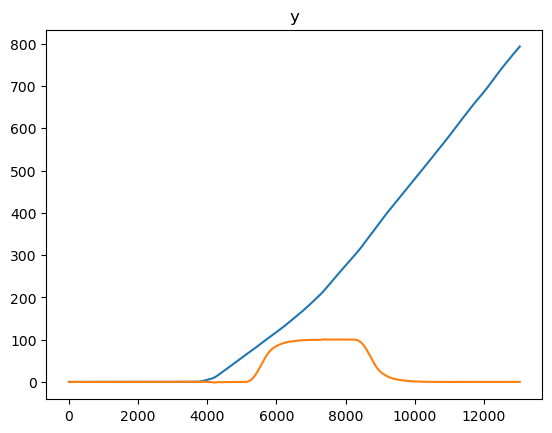

In [68]:
plt.plot(log[:,1])
plt.plot(state_array[:,1])
plt.title("y")

Text(0.5, 1.0, 'z')

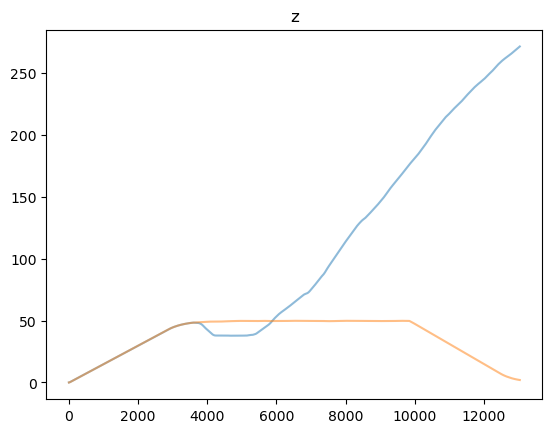

In [69]:
plt.plot(log[:,2], alpha=0.5)
plt.plot(np.array(nominal_states)[:,2], alpha=0.5)
plt.title("z")

Text(0.5, 1.0, 'vx')

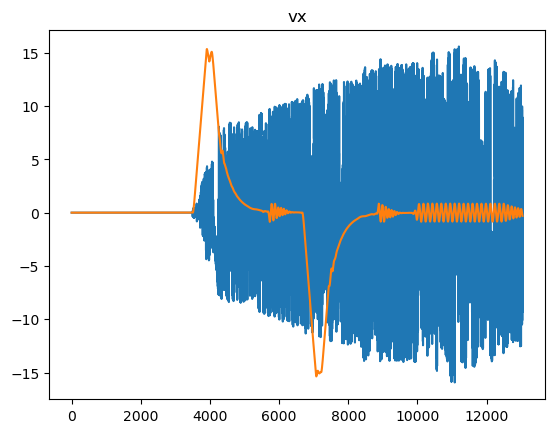

In [70]:
plt.plot(log[:,3])
plt.plot(state_array[:,3])
plt.title("vx")

Text(0.5, 1.0, 'vy')

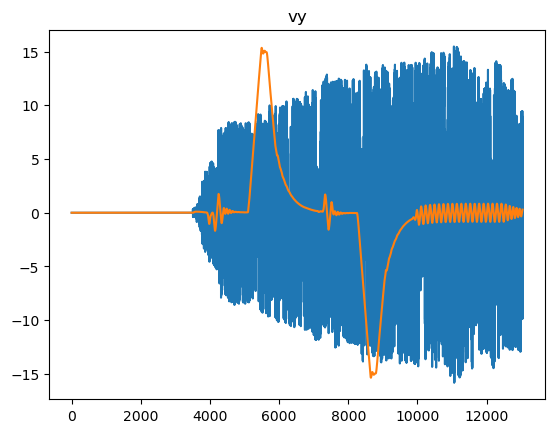

In [71]:
plt.plot(log[:,4])
plt.plot(state_array[:,4])
plt.title("vy")

Text(0.5, 1.0, 'vz')

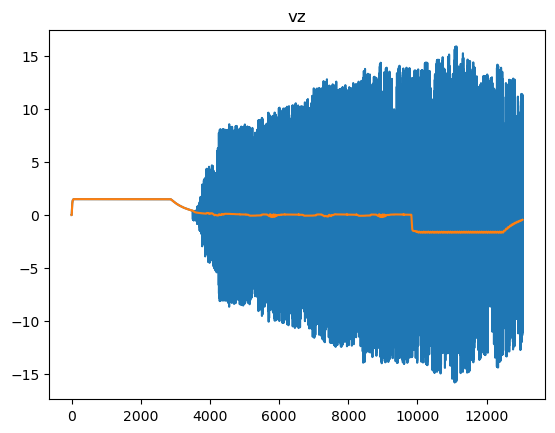

In [72]:
plt.plot(log[:,5])
plt.plot(state_array[:,5])
plt.title("vz")

Text(0.5, 1.0, 'Roll')

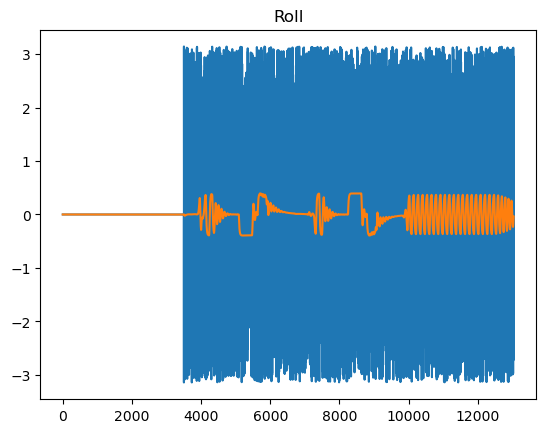

In [73]:
plt.plot(log[:,6])
plt.plot(state_array[:,6])
plt.title("Roll")

Text(0.5, 1.0, 'Pitch')

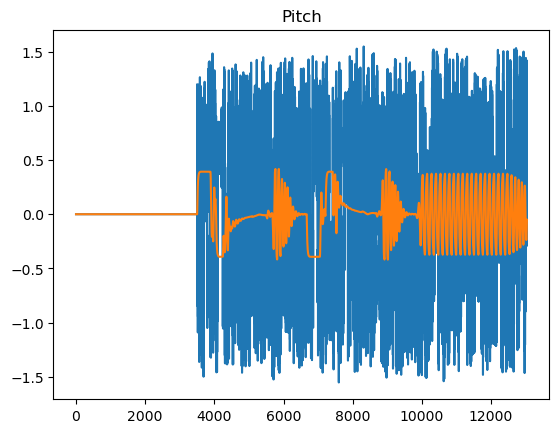

In [74]:
plt.plot(log[:,7])
plt.plot(state_array[:,7])
plt.title("Pitch")

Text(0.5, 1.0, 'Yaw')

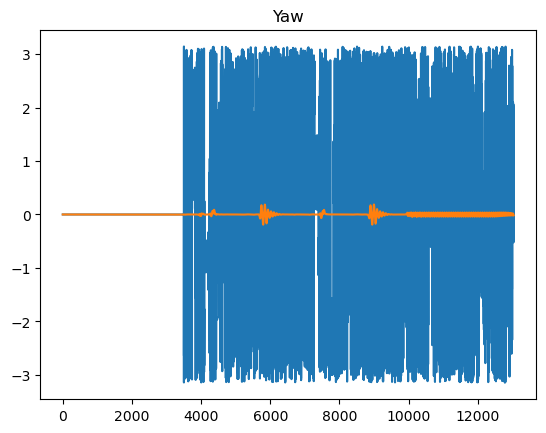

In [75]:
plt.plot(log[:,8])
plt.plot(state_array[:,8])
plt.title("Yaw")